## HW 8: Pattern Extraction & Why Algorithm Chosen (+ Parameter Tuning)
### OCEN 460
### Team: _/Sample_Text/
### Members: Nate Baker and James Frizzell

Overview:

The purpose of this project is to use existing data on the growth of coral to predict whether coral can grow given oceanographic conditions. The latitude, longitude, depth, temperature, salinity, and dissolved oxygen levels are used to predict a binary value with 1 meaning that coral can grow and 0 meaning that coral cannot grow.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import RegscorePy
from math import sqrt, floor
import os
import pathlib
from itertools import product
from scipy.stats import pearsonr
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
%matplotlib inline

Import the necessary packages. Some uncommon ones are RegscorePy, which is a custom open-source library used to calculate the AIC of tensorflow models, and itertools.product which is used to generate all combinations of elements in a list.

## 1) Load data in

The raw data is loaded in from a csv file and processed into a training and testing dataset.

In [2]:
cwd = pathlib.Path(os.getcwd())
path = str(cwd.parent) + '/coral-prediction/processed_data/combined_data_truncated.csv'

raw = pd.read_csv(path)


raw = raw.sample(frac=0.2, random_state=0)

print(raw.describe())

raw.pop('species')
raw.pop('round_d')

train = raw.sample(frac=0.8, random_state=0)
test = raw.drop(train.index)

train_features = train.copy()
test_features = test.copy()

train_labels = train_features['coral_present']
test_labels = test_features['coral_present']
train_features.pop('coral_present')
test_features.pop('coral_present')

       coral_present      latitude     longitude         depth       round_d  \
count   68355.000000  68355.000000  68355.000000  68355.000000  68355.000000   
mean        0.584273     23.283085    -68.820676   1063.477800   1064.483798   
std         0.492850     33.799299     95.889386    985.059453    985.321543   
min         0.000000    -77.875000   -179.966080      0.000000      0.000000   
25%         0.000000     16.875000   -124.591595    235.000000    225.000000   
50%         1.000000     35.652870   -119.501450    855.000000    850.000000   
75%         1.000000     40.811420    -26.375000   1735.000000   1750.000000   
max         1.000000     89.625000    179.973800   5500.000000   5500.000000   

        temperature      salinity        oxygen  
count  68355.000000  68355.000000  68355.000000  
mean       5.175744     34.384281     42.198043  
std        4.551002      1.371827     29.077581  
min       -2.248000      0.022000      0.434000  
25%        2.457000     34.22

304228    0
213311    0
172619    1
141430    1
133490    1
         ..
267861    0
209754    0
192209    1
36135     1
278318    0
Name: coral_present, Length: 13671, dtype: int64

## 2) Feature evaluation - correlation coefficients

The correlation coefficients and p-values for each feature are reported. Since all p-values are <0.05, each feature selected is relevant to the model and will be kept.

It is interesting that the longitude is strongly negatively correlated to the presence of coral. This implies that at more eastern locations (say 90E - 180E) it is less likely that coral will grow. This may be a residual of other conditions, such as the much deeper waters in the eastern Pacific Ocean - since the depth is also negatively correlated.

In [3]:
print(train.corr()['coral_present'])
print(pearsonr(train_features['latitude'], train_labels))
print(pearsonr(train_features['longitude'], train_labels))
print(pearsonr(train_features['depth'], train_labels))
print(pearsonr(train_features['temperature'], train_labels))
print(pearsonr(train_features['salinity'], train_labels))
print(pearsonr(train_features['oxygen'], train_labels))

coral_present    1.000000
latitude         0.483094
longitude       -0.623733
depth           -0.381216
temperature      0.244996
salinity        -0.075697
oxygen          -0.484223
Name: coral_present, dtype: float64
(0.48309400646187506, 0.0)
(-0.6237334337918604, 0.0)
(-0.38121618825430753, 0.0)
(0.2449964411644198, 0.0)
(-0.07569703383008823, 2.618925049563251e-70)
(-0.4842228643655442, 0.0)


## 3) Function definitions

The following functions were used during the training and evaluation of the model.

fit_and_evaluate() accepts a model architecture and fits the training data to it, and the reports the accuracy metrics based on the test dataset.

The hyperparameters selected for the training are: 20% validation split and 50 epochs training duration. These were selected by testing different configurations and choosing the hyperparameters that resulted in the most accurate model.

plot_loss() accepts the model training residuals and plots them over the training duration (number of epochs) the loss and validation loss are both shown.

add_layer() is a part of the parametric model study, which can add hidden layers to a tensorflow model by passing parameters and hyperparameters. This functionality will hopefully be bundled into a package at some point so that users can pip install the ability to do a parametric study.

build_and_compile_model() accepts the model architecture from the user and creates the tensorflow model. It then fits the model and performs the accuracy evaluations.

In [4]:
def fit_and_evaluate(architecture):
    dnn_model = build_and_compile_model(architecture)

    history = dnn_model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=50)
    plot_loss(history)

    test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
    test_predictions = dnn_model.predict(test_features).flatten()
    r2= r2_score(np.asarray(test_labels).flatten(), test_predictions)
    mae = mean_absolute_error(np.asarray(test_labels).flatten(), test_predictions)
    aic = RegscorePy.aic.aic(np.asarray(test_labels, dtype=float).flatten(), np.asarray(test_predictions).astype(float), 4+2)
    rmse = sqrt(mean_squared_error(np.asarray(test_labels).flatten(), test_predictions))
    return dnn_model, aic, r2, mae, rmse, test_predictions

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 30])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    # pass

In [6]:
def add_layer(dets, hyper, prev):
    default = ['relu']
    try:
        layer = layers.Dense(dets, activation=hyper[0])(prev)
    except IndexError:
        layer = layers.Dense(dets, activation=default[0])(prev)
    return layer

In [7]:
def build_and_compile_model(arch):
    # Adjust the number of hidden layers and neurons per layer that results in best fit NN
    hidden_layers = []
    inputs = keras.Input(shape=(6,))
    norm_layer = layers.BatchNormalization()(inputs)
    hidden_layers.append(inputs)
    hidden_layers.append(norm_layer)
    for i in range(num_hidden):
        if arch[i] == 0:
            pass
        else:
            layer = add_layer(arch[i], arch[num_hidden:], hidden_layers[-1])
            hidden_layers.append(layer)
            layer = layers.Dropout(rate=0.2)(hidden_layers[-1])
            hidden_layers.append(layer)
    outputs = layers.Dense(1)(hidden_layers[-1])
    hidden_layers.append(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## 4) Using the model trainer

The following code sets up the necessary data to train the models. By commenting out the line:

list(product(\*[l1, l2, l3, activ])), the parametric search is deactivated, and only the architecture specified in the next line is fitted

Additionally, some timing features are implemented. Passing a large parametric space can result in the program running for over 4 hours, training each model. Because of this, a progress meter is added so that the user can see how far along the program is.

In [8]:
models = []
aic_scores = []
r2_scores = []
maes = []
rmses = []
l1 = np.linspace(32, 256, 5)
l2 = np.linspace(0, 256, 5)
l3 = np.linspace(0, 256, 5)
activ = ['relu', 'tanh']
# parametric_space = list(product(*[l1, l2, l3, activ]))
parametric_space = [[200, 64, 192, 'relu']]
print(parametric_space)
num_hidden = len(list(i for i in parametric_space[0] if isinstance(i, (int or float))))
num_hyper = len(parametric_space[0]) - num_hidden
start_t = time.time()
c = 1

[[200, 64, 192, 'relu']]


## 5) Running the model training

This for loop passes each architecture specified in the parametric space into the build_and_compile_model() function and reports the accuracy metrics into their specific list. It also updates the progress each time a model is finished evaluation

Progress: 1/1


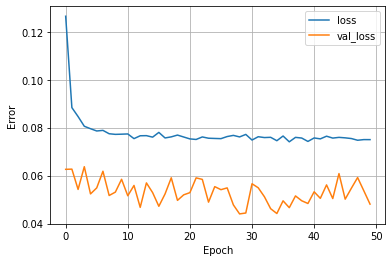

Estimated Time Remaining: 00:00:00 seconds


In [9]:
for arch in parametric_space:
    print('Progress: ' + str(c) + '/' + str(len(parametric_space)))
    dnn_model, aic, r2, mae, rmse, test_predictions = fit_and_evaluate(arch)
    models.append(dnn_model)
    aic_scores.append(aic)
    r2_scores.append(r2)
    maes.append(mae)
    rmses.append(rmse)

    curr_time = time.time()
    diff_t = curr_time - start_t
    t_per_model = diff_t / c
    num_mods_rem = len(parametric_space) - c
    t_rem = t_per_model * num_mods_rem
    print("Estimated Time Remaining: " + time.strftime('%H:%M:%S', time.gmtime(t_rem)) + ' seconds')
    c += 1

## 6) Choosing the best model

After the parametric seach is finished, the accuracy metrics are compiled into a csv file. The user must look through these results and pick the model which has the LOWEST AIC score and HIGHEST R-Squared. 

The final 2 lines save the 0-th model in the parametric space for later use. During the parametric seach, this should be disabled because the 0-th model is likely not the most accurate. When the parametric search is disabled (only a single architecture is being fitted) this can be re-enabled to save the model.

In [10]:
parametric_space_t = np.asarray(parametric_space).transpose().tolist()
output_data = [parametric_space_t[0], parametric_space_t[1], parametric_space_t[2], aic_scores, maes, rmses, r2_scores]
output_data = np.asarray(output_data).transpose().tolist()
print(output_data)
oput = pd.DataFrame(output_data, columns=['L1', 'L2', 'L3', 'AIC', 'MAE', 'RMSE', 'R2'])
# print(oput)
# oput.to_csv('Parametric_space_study.csv', index=False)
print(models[0].summary())
out_path = str(cwd.parent) + '/models/trial0.3.h5'
# models[0].save(out_path)

[['200', '64', '192', '-42249.02537623041', '0.04866076749821012', '0.21317433109464726', '0.8131798652629634']]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 200)               1400      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12864     
                                                                 
 dropout_1 (Dr